In [162]:
import pandas as pd 
import numpy as np
import os 
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plots
markers = ['o', 's', 'D', 'v', 'p', 'P', 'X', 'h', 'H', 'd']
colors_discrete = sns.color_palette('tab10')
colors_continuous = sns.color_palette('viridis')
linestyles = ['-', '--', '-.', ':']


# Do not hide any columns
pd.set_option('display.max_columns', None)

results_path = 'results_combined'
images_dir = f'{results_path}/images'
results_list = []
recover_list = [] 

# Read all the results from results/ directory
for dirs in os.listdir(results_path):
    results = {}
    recover = {}
    if 'results' in dirs:
        if not os.path.isdir(f'{results_path}/{dirs}'):
            continue
        for file in os.listdir(f'{results_path}/{dirs}/results'):
            if file.endswith('.feather') and '__9' not in dirs:
                number = int(file.split('_')[0])
                res_pd = pd.read_feather(f'{results_path}/{dirs}/results/{file}')
                rec_pd = pd.read_feather(f'{results_path}/{dirs}/recover/{file}')
                
                res_pd = res_pd[res_pd['dataset_name'] != 'breast_cancer']
                rec_pd = rec_pd[rec_pd['dataset_name'] != 'breast_cancer']
                
                if '__9' in dirs:
                    res_pd = res_pd[res_pd['base_counterfactual_time'].isna()]
                
                results[number] = res_pd
                recover[number] = rec_pd
                
                

    sorted_keys = sorted(results.keys()) 
    for k in sorted_keys:
        results_list.append(results[k])
        recover_list.append(recover[k])
    
    print(f'Processed {dirs} directory')
    # break
    
# Concatenate all the results
raw_df: pd.DataFrame = pd.concat(results_list, ignore_index=True)
recover_df: pd.DataFrame = pd.concat(recover_list, ignore_index=True)
# print(recover_df.info())
raw_df.head(3)

Processed results_wine1__9 directory
Processed results_breast1 directory
Processed results_breast2__9 directory
Processed robx directory
Processed results_fico2 directory
Processed results_breast2 directory
Processed results_breast1__9 directory
Processed results_fico1__9 directory
Processed results_fico2__9 directory
Processed results_wine1 directory
Processed results_fico1 directory
Processed images directory
Processed results_wine2 directory
Processed results_wine2__9 directory


,experiment_type,dataset_name,k_mlps_in_B,fold_i,experiment_generalization_type,beta_confidence,delta_robustness,model2_name,x_test_sample,y_test_sample,model1_pred_proba,model1_pred_crisp,model2_pred_proba,model2_pred_crisp,base_counterfactual,base_counterfactual_model1_pred_proba,base_counterfactual_model1_pred_crisp,base_counterfactual_model2_pred_proba,base_counterfactual_model2_pred_crisp,base_counterfactual_validity,base_counterfactual_proximityL1,base_counterfactual_proximityL2,base_counterfactual_plausibility,base_counterfactual_discriminative_power,base_counterfactual_validity_model2,base_counterfactual_time,robust_counterfactual,robust_counterfactual_model1_pred_proba,robust_counterfactual_model1_pred_crisp,robust_counterfactual_model2_pred_proba,robust_counterfactual_model2_pred_crisp,robust_counterfactual_validity,robust_counterfactual_proximityL1,robust_counterfactual_proximityL2,robust_counterfactual_plausibility,robust_counterfactual_discriminative_power,robust_counterfactual_validity_model2,robust_counterfactual_L1_distance_from_base_cf,robust_counterfactual_L2_distance_from_base_cf,robust_counterfactual_time,start_sample_passes_test,counterfactual_does_not_pass_test,counterfactual_does_not_have_target_class,counterfactual_is_nan,highest_delta,lower_bound_beta,upper_bound_beta
0,Seed-Architecture,fico,32,0,Seed-Architecture,0.95,0.5,Model2_0,"[0.423076923076923, 0.19064124783362218, 0.192...",0,0.088027,0,0.118728,0,"[0.42316228322143384, 0.5902224921053054, 0.11...",0.537076,1.0,0.550801,1.0,1.0,3.181537,0.836189,0.768268,0.533333,1.0,0.014567,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Seed-Architecture,fico,32,0,Seed-Architecture,0.95,0.5,Model2_0,"[0.423076923076923, 0.19064124783362218, 0.192...",0,0.088027,0,0.118728,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.42307306858971444, 0.5909860253154476, 0.11...",0.54029,1.0,0.55418,1.0,1.0,3.209884,0.84118,0.771598,0.533333,1.0,0.039621,0.000115,2.160914,0.0,0.0,0.0,0.0,0.516128,0.516128,0.826645
2,Seed-Architecture,fico,32,0,Seed-Architecture,0.95,0.5,Model2_1,"[0.423076923076923, 0.19064124783362218, 0.192...",0,0.088027,0,0.128949,0,"[0.42316228322143384, 0.5902224921053054, 0.11...",0.537076,1.0,0.509835,1.0,1.0,3.181537,0.836189,0.768268,0.533333,1.0,0.014567,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
# Pair up the results and recover dataframes

raw_df_mod = raw_df.copy()
# raw_df_mod = raw_df_mod[raw_df_mod['base_counterfactual_time'].isna()]
# raw_df_mod = raw_df_mod[raw_df_mod['dataset_name'] != 'breast_cancer']
print(len(raw_df_mod))

recover_df_mod = recover_df.copy()
# recover_df_mod = recover_df_mod[recover_df_mod['dataset_name'] != 'breast_cancer']
print(len(recover_df_mod))

129600
128301


In [58]:
raw_df_mod[['beta_confidence', 'delta_robustness']] = recover_df_mod[['beta_confidence', 'delta_robustness']]
raw_df_mod.head()

,experiment_type,dataset_name,k_mlps_in_B,fold_i,experiment_generalization_type,beta_confidence,delta_robustness,model2_name,x_test_sample,y_test_sample,model1_pred_proba,model1_pred_crisp,model2_pred_proba,model2_pred_crisp,base_counterfactual,base_counterfactual_model1_pred_proba,base_counterfactual_model1_pred_crisp,base_counterfactual_model2_pred_proba,base_counterfactual_model2_pred_crisp,base_counterfactual_validity,base_counterfactual_proximityL1,base_counterfactual_proximityL2,base_counterfactual_plausibility,base_counterfactual_discriminative_power,base_counterfactual_validity_model2,base_counterfactual_time,robust_counterfactual,robust_counterfactual_model1_pred_proba,robust_counterfactual_model1_pred_crisp,robust_counterfactual_model2_pred_proba,robust_counterfactual_model2_pred_crisp,robust_counterfactual_validity,robust_counterfactual_proximityL1,robust_counterfactual_proximityL2,robust_counterfactual_plausibility,robust_counterfactual_discriminative_power,robust_counterfactual_validity_model2,robust_counterfactual_L1_distance_from_base_cf,robust_counterfactual_L2_distance_from_base_cf,robust_counterfactual_time,start_sample_passes_test,counterfactual_does_not_pass_test,counterfactual_does_not_have_target_class,counterfactual_is_nan,highest_delta,lower_bound_beta,upper_bound_beta,__9
15252,Seed-Architecture,fico,32,0,Seed-Architecture,0.95,0.5,Model2_0,"[0.423076923076923, 0.19064124783362218, 0.192...",0,0.088027,0,0.118728,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.42307306858971444, 0.5909860253154476, 0.11...",0.540290,1.0,0.554180,1.0,1.0,3.209884,0.841180,0.771598,0.533333,1.0,0.039621,0.000115,2.160914,0.0,0.0,0.0,0.0,0.516128,0.516128,0.826645,False
15254,Seed-Architecture,fico,32,0,Seed-Architecture,0.95,0.5,Model2_1,"[0.423076923076923, 0.19064124783362218, 0.192...",0,0.088027,0,0.128949,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.4245640109844605, 0.5957025882966385, 0.115...",0.539483,1.0,0.512998,1.0,1.0,3.196112,0.838867,0.768577,0.466667,1.0,0.124203,0.001046,1.918790,0.0,0.0,0.0,0.0,0.549133,0.549133,0.850784,False
15256,Seed-Architecture,fico,32,0,Seed-Architecture,0.95,0.5,Model2_2,"[0.423076923076923, 0.19064124783362218, 0.192...",0,0.088027,0,0.115540,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.4250315962547223, 0.5932593673768348, 0.113...",0.540475,1.0,0.554259,1.0,1.0,3.196203,0.840699,0.770566,0.533333,1.0,0.031933,0.000074,1.810500,0.0,0.0,0.0,0.0,0.516128,0.516128,0.826645,False
15258,Seed-Architecture,fico,32,0,Seed-Architecture,0.95,0.5,Model2_3,"[0.423076923076923, 0.19064124783362218, 0.192...",0,0.088027,0,0.126658,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.4233617846618841, 0.5917734438170048, 0.115...",0.539684,1.0,0.514060,1.0,1.0,3.182554,0.836783,0.767490,0.533333,1.0,0.040788,0.000127,1.775246,0.0,0.0,0.0,0.0,0.516128,0.516128,0.826645,False
15260,Seed-Architecture,fico,32,0,Seed-Architecture,0.95,0.5,Model2_4,"[0.423076923076923, 0.19064124783362218, 0.192...",0,0.088027,0,0.115540,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.4213533253018529, 0.5914409980248029, 0.119...",0.543297,1.0,0.554296,1.0,1.0,3.182228,0.836638,0.768095,0.466667,1.0,0.074813,0.000340,1.702226,0.0,0.0,0.0,0.0,0.549133,0.549133,0.850784,False


In [59]:
# Prep
raw_df = raw_df[~((raw_df['delta_robustness'] == 0.9) & (raw_df['robust_counterfactual_plausibility'].isna()))]
raw_df = raw_df[raw_df['dataset_name'] != 'breast_cancer']

In [60]:
np.sum(((raw_df['delta_robustness'] == 0.7).to_numpy() & raw_df['robust_counterfactual_plausibility'].notna().to_numpy()))

21600

In [61]:
np.sum((raw_df['start_sample_passes_test'] == 0))

67620

In [62]:
raw_df['start_sample_passes_test'].value_counts()

0.0    67620
1.0    18780
Name: start_sample_passes_test, dtype: int64

In [63]:
base_validity_model2 = raw_df[raw_df['base_counterfactual'] != None]['base_counterfactual_validity_model2']
print('Average base_counterfactual_validity_model2:', base_validity_model2.mean())
print('Notna %:', base_validity_model2.notna().sum() / base_validity_model2.shape[0])

robust_validity_model2 = raw_df[raw_df['robust_counterfactual'] != None]['robust_counterfactual_validity_model2']
print('Average robust_counterfactual_validity_model2:', robust_validity_model2.mean())
print('Notna %:', robust_validity_model2.notna().sum() / robust_validity_model2.shape[0])

Average base_counterfactual_validity_model2: 0.5193518518518518
Notna %: 0.2
Average robust_counterfactual_validity_model2: 0.8476851851851852
Notna %: 0.8


In [64]:
raw_df['dataset_name'].value_counts()

fico            54000
wine_quality    54000
Name: dataset_name, dtype: int64

In [65]:
raw_df['experiment_type'].value_counts()

Seed-Architecture              27000
Seed-Bootstrap-Architecture    27000
Bootstrap-Architecture         27000
Seed-Bootstrap                 27000
Name: experiment_type, dtype: int64

In [66]:
raw_df['beta_confidence'].value_counts()

0.95    108000
Name: beta_confidence, dtype: int64

In [67]:
raw_df['delta_robustness'].value_counts()

0.5    43200
0.6    21600
0.7    21600
0.8    21600
Name: delta_robustness, dtype: int64

In [68]:
def filter_by(df, dataset_name=None, experiment_type=None, beta_confidence=None, delta_robustness=None):
    if dataset_name is not None:
        df = df[df['dataset_name'] == dataset_name]
    if experiment_type is not None:
        df = df[df['experiment_type'] == experiment_type]
    if beta_confidence is not None:
        df = df[df['beta_confidence'] == beta_confidence]
    if delta_robustness is not None:
        df = df[df['delta_robustness'] == delta_robustness]
    return df

In [69]:

def plot_validity_by_delta(df, dataset_name, beta_confidence, experiment_type):    
    robust_optim = []
    robust_optim_ci = []
    robust_start = []
    robust_start_ci = []
    robust_combined = []
    robust_combined_ci = []
    base = []
    base_ci = []
    
    z = 1.96  # z-score for 95% confidence
    
    unique_deltas = sorted(df['delta_robustness'].unique())
    print(unique_deltas)

    exp1_df = filter_by(raw_df.copy(), dataset_name=dataset_name, experiment_type=experiment_type, beta_confidence=beta_confidence)
    print(f'Filtered df shape: {exp1_df.shape}')

    for delta in unique_deltas:
        robust_data = exp1_df[(exp1_df['delta_robustness'] == delta) & (exp1_df['beta_confidence'] == beta_confidence) & (exp1_df['start_sample_passes_test'] == 0)]['robust_counterfactual_validity_model2'].dropna()
        
        if len(robust_data) == 0:
            print('Nan found')
            robust_optim.append(0)
            robust_optim_ci.append(0)
        else:
            robust_mean = robust_data.mean()
            robust_optim.append(robust_mean)
            robust_optim_ci.append(z * np.sqrt((robust_mean*(1-robust_mean))/len(robust_data)))
            
        robust_data = exp1_df[(exp1_df['delta_robustness'] == delta) & (exp1_df['beta_confidence'] == beta_confidence) & (exp1_df['start_sample_passes_test'] == 1)]['robust_counterfactual_validity_model2'].dropna()
        if len(robust_data) == 0:
            print('Nan found')
            robust_start.append(0)
            robust_start_ci.append(0)
        else:
            robust_mean = robust_data.mean()
            robust_start.append(robust_mean)
            robust_start_ci.append(z * np.sqrt((robust_mean*(1-robust_mean))/len(robust_data)))
        
        robust_data = exp1_df[(exp1_df['delta_robustness'] == delta) & (exp1_df['beta_confidence'] == beta_confidence)]['robust_counterfactual_validity_model2'].dropna()
        if len(robust_data) == 0:
            print('Nan found')
            robust_combined.append(0)
            robust_combined_ci.append(0)
        else:
            robust_mean = robust_data.mean()
            robust_combined.append(robust_mean)
            robust_combined_ci.append(z * np.sqrt((robust_mean*(1-robust_mean))/len(robust_data)))

        base_data = exp1_df[(exp1_df['delta_robustness'] == delta) & (exp1_df['beta_confidence'] == beta_confidence)]['base_counterfactual_validity_model2'].dropna()
        base_mean = base_data.mean()
        base.append(base_mean if not pd.isna(base_mean) else base[0])
        base_ci.append(z * np.sqrt((base_mean*(1-base_mean))/len(base_data)) if not pd.isna(base_mean) else base_ci[0])


    fig, ax = plt.subplots(1, 1, figsize=(5, 4))

    # plt.title(f'Empirical validity for model 2 @ {int(beta_confidence*100)}% (Beta) confidence \nWith 95% confidence error bars')
    plt.xlabel('Delta-robustness threshold')
    plt.ylabel('Validity for model 2')

    plt.errorbar(unique_deltas, base, yerr=base_ci, label='Base cf', marker=markers[3], color=colors_discrete[3], linestyle=linestyles[3])
    plt.errorbar(unique_deltas, robust_start, yerr=robust_start_ci, label='Robust cf (Base passed)', marker=markers[2], color=colors_discrete[2], linestyle=linestyles[2])
    plt.errorbar(unique_deltas, robust_optim, yerr=robust_optim_ci, label='Robust cf (Optimized)', marker=markers[1], color=colors_discrete[1], linestyle=linestyles[1])
    plt.errorbar(unique_deltas, robust_combined, yerr=robust_combined_ci, label='Robust cf (Combined)', marker=markers[0], color=colors_discrete[0], linestyle=linestyles[0])

    plt.grid(axis='y')
    # Add some offset to the legend
    # plt.legend(loc='right', fontsize='small', title='Counterfactual type', title_fontsize='small', bbox_to_anchor=(1, -0.5), ncol=2)
    plt.tight_layout()
    
    os.makedirs(f'{images_dir}/plot_validity_by_delta', exist_ok=True)
    plt.savefig(f'{images_dir}/plot_validity_by_delta/{dataset_name}_{experiment_type}_{int(beta_confidence*100)}.png', dpi=300, bbox_inches='tight')
    
    # Create separate legend plot and save it
    _, ax2 = plt.subplots(1, 1, figsize=(4, 1))
    ax2.axis('off')
    ax2.legend(*ax.get_legend_handles_labels(), loc='center', title='Counterfactual type',  ncol=4)
    plt.tight_layout()
    plt.savefig(f'{images_dir}/plot_validity_by_delta/legend.png', dpi=300, bbox_inches='tight')
    
    # Flush the plot
    plt.close()
    
    return None
    

[0.5, 0.6, 0.7, 0.8]
Filtered df shape: (13500, 48)


/tmp/ipykernel_24943/795549710.py:80: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


[0.5, 0.6, 0.7, 0.8]
Filtered df shape: (13500, 48)
[0.5, 0.6, 0.7, 0.8]
Filtered df shape: (13500, 48)
[0.5, 0.6, 0.7, 0.8]
Filtered df shape: (13500, 48)
[0.5, 0.6, 0.7, 0.8]
Filtered df shape: (13500, 48)
[0.5, 0.6, 0.7, 0.8]
Filtered df shape: (13500, 48)
[0.5, 0.6, 0.7, 0.8]
Filtered df shape: (13500, 48)
[0.5, 0.6, 0.7, 0.8]
Filtered df shape: (13500, 48)
Done


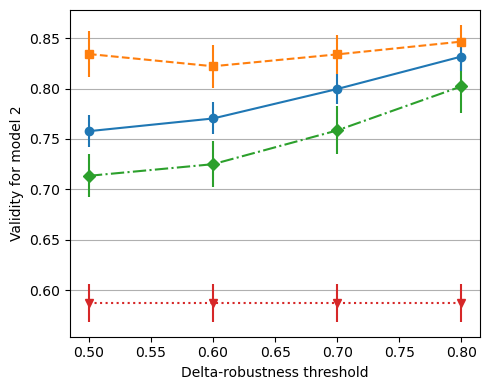

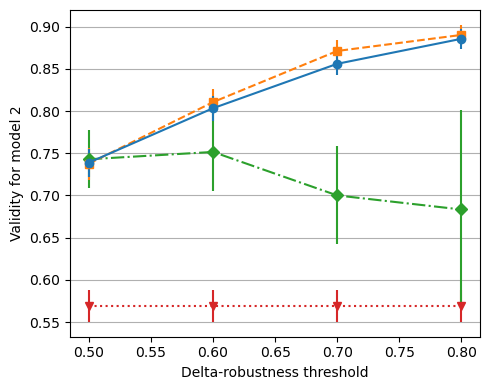

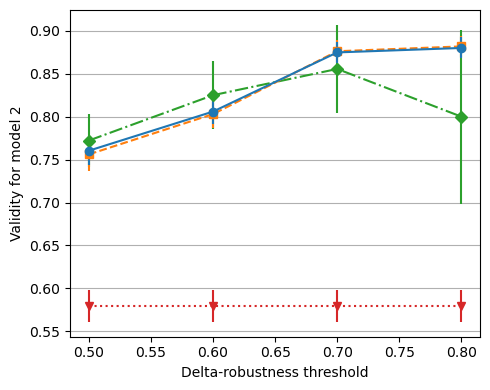

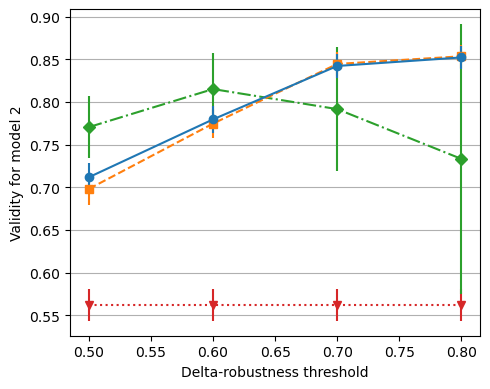

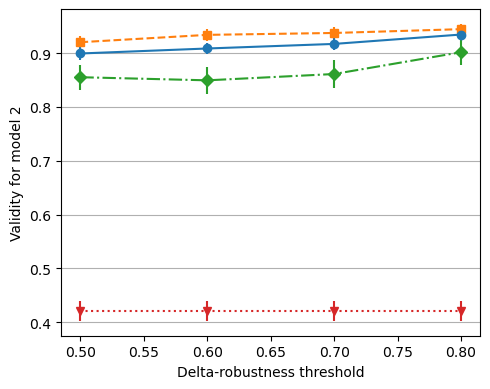

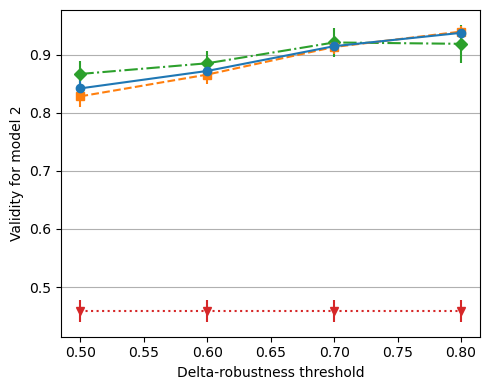

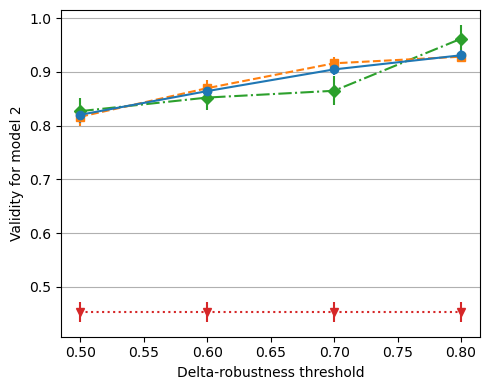

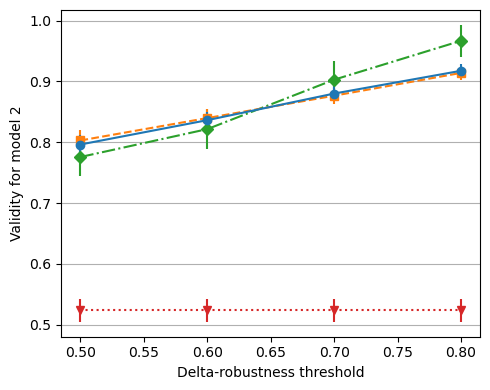

In [70]:
import numpy as np

confidence = 0.95

for dataset_name in raw_df['dataset_name'].unique():
    for experiment_type in raw_df['experiment_type'].unique():
        for beta_confidence in raw_df['beta_confidence'].unique():
            _ = plot_validity_by_delta(raw_df, dataset_name, beta_confidence, experiment_type)
            
print('Done')

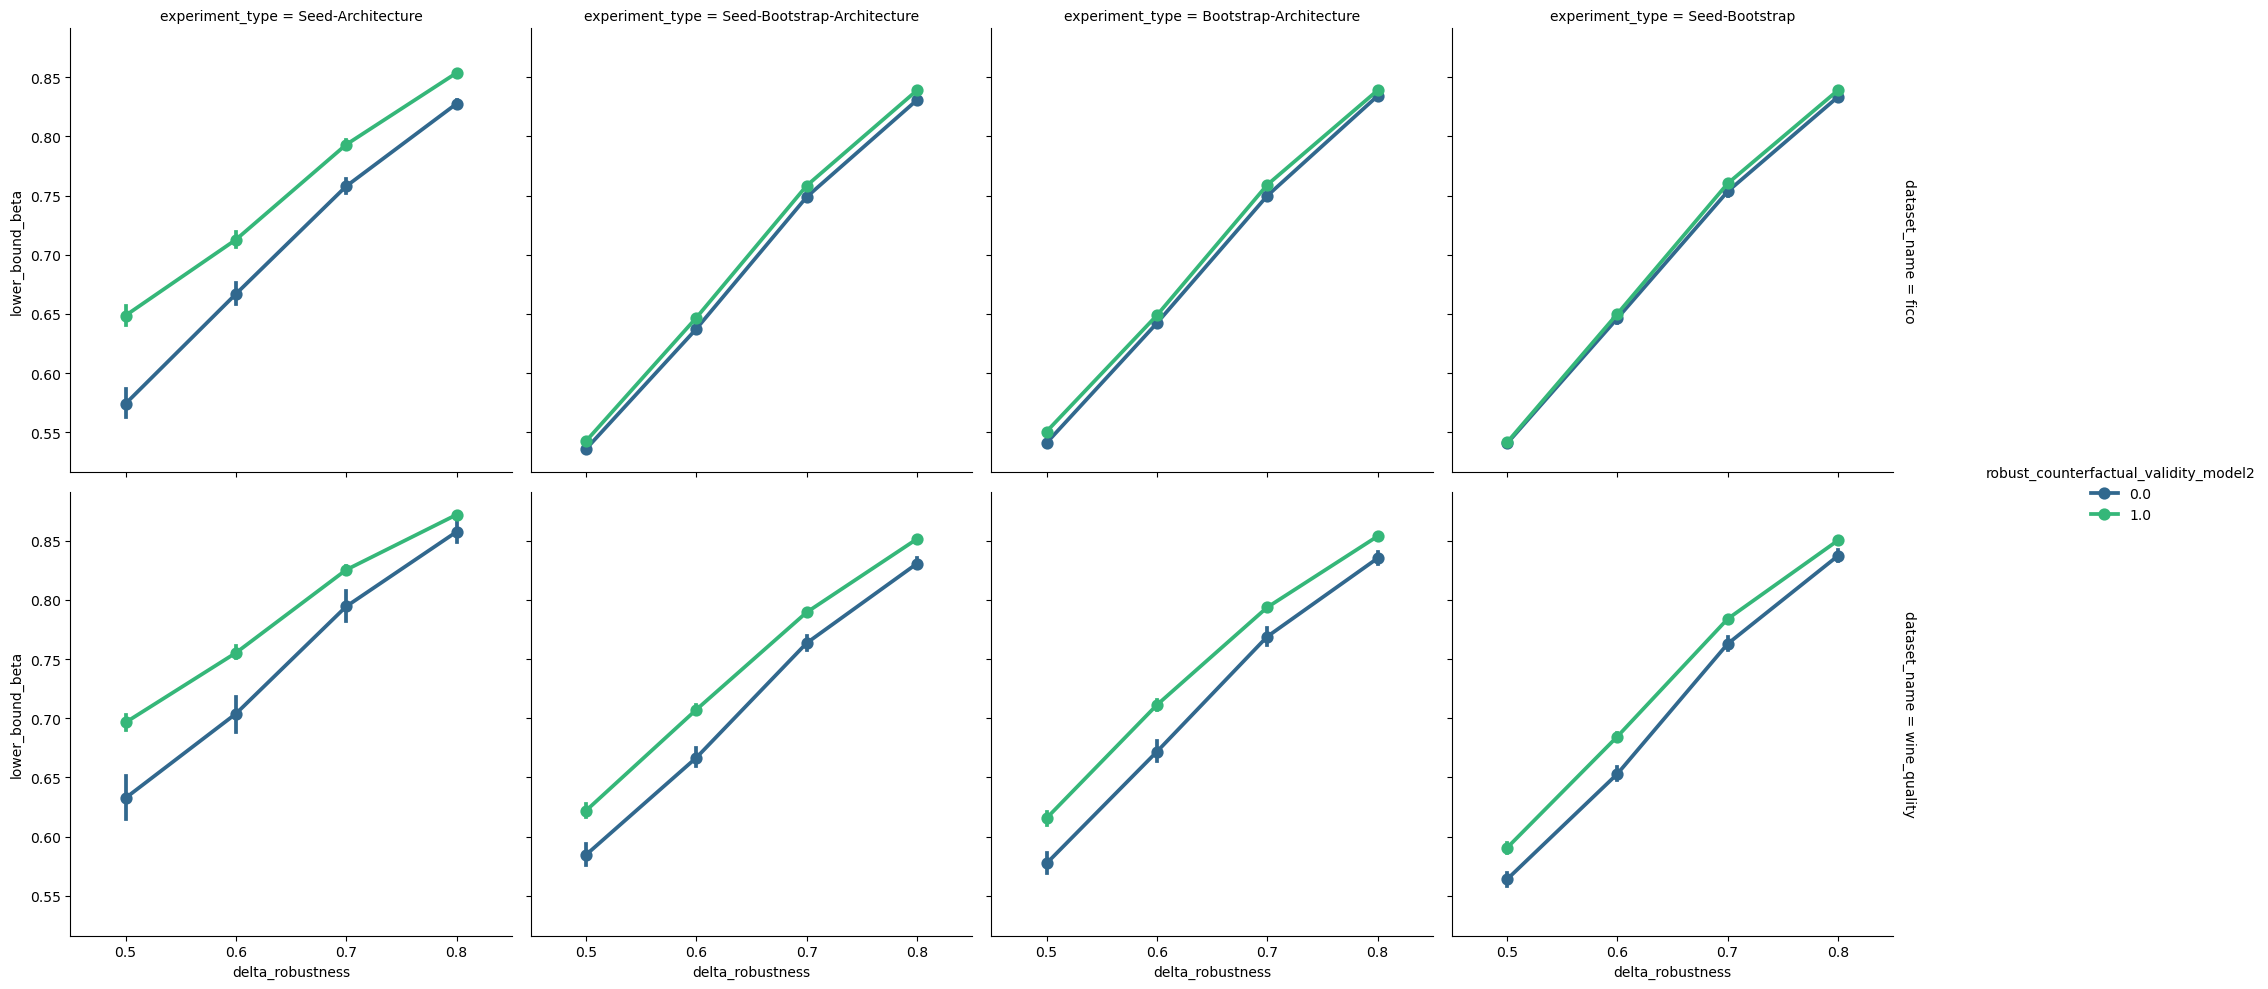

In [71]:
sns.catplot(data=raw_df,
            # data selection 
            x='delta_robustness', 
            y='lower_bound_beta', 
            col='experiment_type', 
            row='dataset_name', 
            hue='robust_counterfactual_validity_model2', 
            # settings
            kind='point', 
            # errorbar='se',
            # fill=True, 
            palette='viridis',  
            margin_titles=True,
        
)

os.makedirs(f'{images_dir}/misc', exist_ok=True)
plt.savefig(f'{images_dir}/misc/delta_robustness_vs_lower_bound_beta.png', dpi=300, bbox_inches='tight')



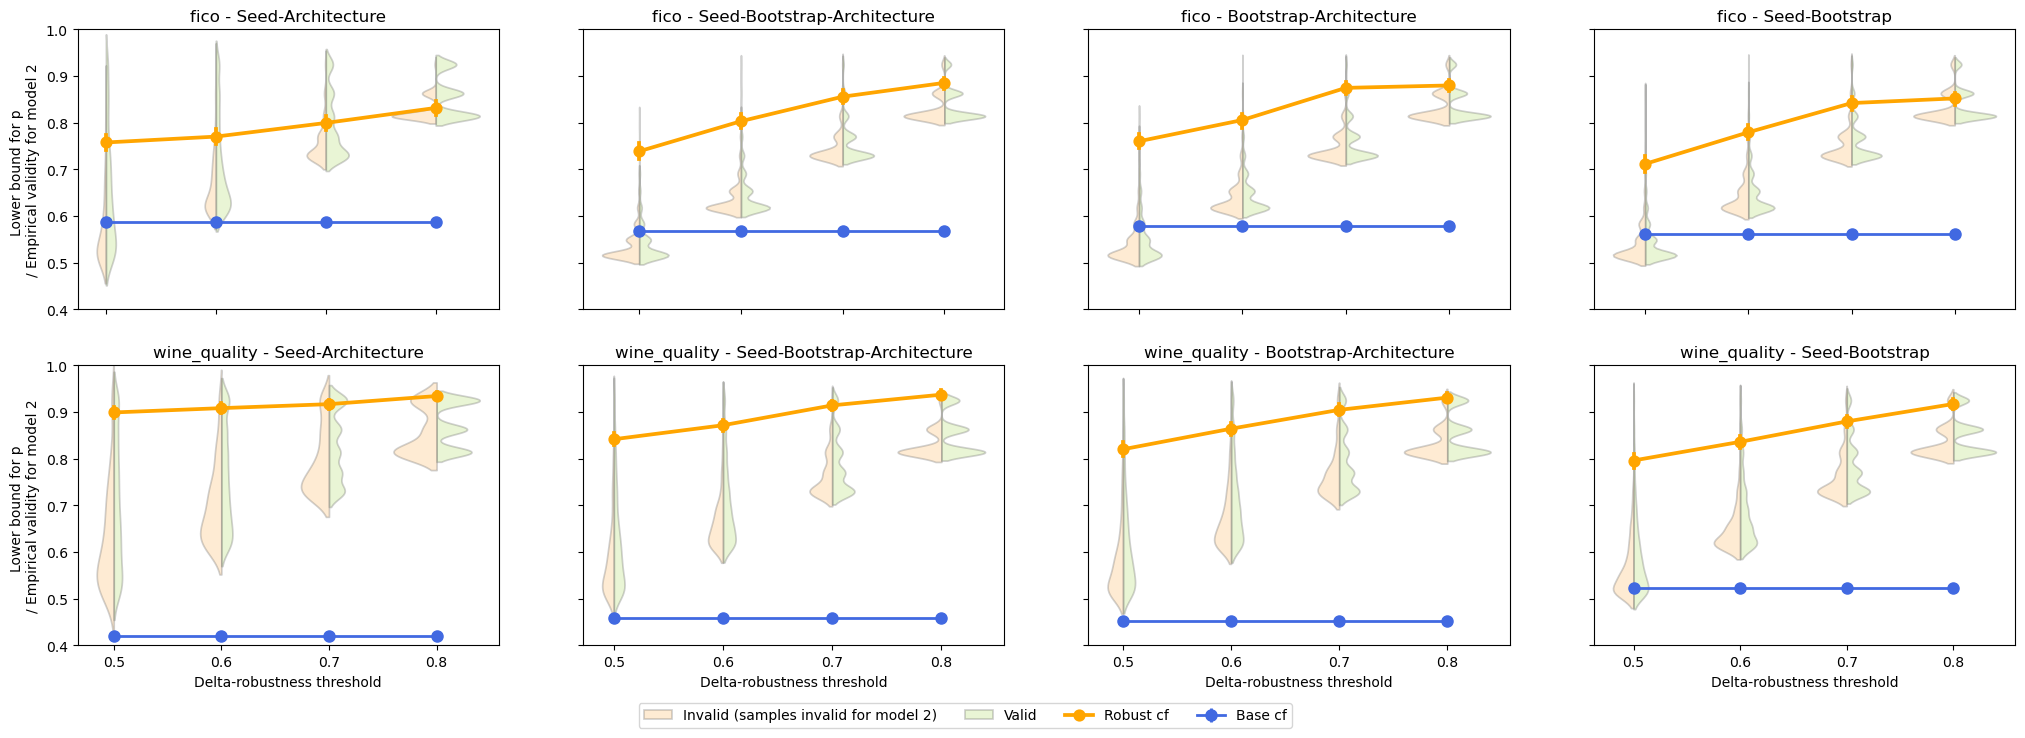

In [72]:
# Create an aggregated plot of the average validity for model 2
rows = len(raw_df['dataset_name'].unique())
cols = len(raw_df['experiment_type'].unique())
fig, ax = plt.subplots(rows, cols, figsize=(25, 8))



# Add horizontal line plots for the base counterfactual validity
axes = ax.flatten()
for i, dataset in enumerate(raw_df['dataset_name'].unique()):
    for j, experiment in enumerate(raw_df['experiment_type'].unique()):
        ax = axes[i * cols + j]
        
        sns.violinplot(data=raw_df[(raw_df['dataset_name'] == dataset) & (raw_df['experiment_type'] == experiment)], 
                       x='delta_robustness', 
                       y='lower_bound_beta', 
                       hue='robust_counterfactual_validity_model2', 
                       split=True, 
                       inner=None,
                       legend=True if i == rows - 1 and j == cols - 1 else False,
                       ax=ax,
                       alpha=0.3,
                       saturation=1,
                       palette='RdYlGn',
        )
        
        sns.pointplot(data=raw_df[(raw_df['dataset_name'] == dataset) & (raw_df['experiment_type'] == experiment)],
                    # data selection 
                    x='delta_robustness', 
                    y='robust_counterfactual_validity_model2', 
                    errorbar='ci',
                    legend=True if i == rows - 1 and j == cols - 1 else False,
                    color='orange',
                    ax=ax,
                    label='Robust cf',
                
        )
        
        
        
        mean = raw_df[(raw_df['dataset_name'] == dataset) & (raw_df['experiment_type'] == experiment)]['base_counterfactual_validity_model2'].mean()
        # ax.axhline(mean, color='royalblue', linestyle='-', linewidth=2)
        # add std error bars at each point
        se = raw_df[(raw_df['dataset_name'] == dataset) & (raw_df['experiment_type'] == experiment)]['base_counterfactual_validity_model2'].sem()
        
        ticks = ax.get_xticks()
        ax.errorbar(ticks, [mean] * len(ticks), yerr=[se] * len(ticks), color='royalblue', linestyle='-', label='Base cf', linewidth=2, marker='o', markersize=8)
        
        if j == 0:
            ax.set_ylabel('Lower bound for p \n/ Empirical validity for model 2')
        else: 
            ax.set_ylabel('')
            ax.set_yticklabels([])
        if i == rows - 1:
            ax.set_xlabel('Delta-robustness threshold')
        else:
            ax.set_xlabel('')
            if i == 0:
                ax.set_xticklabels([])
            
        
            
        ax.set_title(f'{dataset} - {experiment}')
        
        # Make sure that y-axis is shared between the plots 
        ax.set_ylim(0.4, 1)
        ax.set_yticks(np.arange(0.4, 1.1, 0.1))
                
# Create the legend
handles, labels = ax.get_legend_handles_labels()

labels = ['Invalid (samples invalid for model 2)', 'Valid', 'Robust cf', 'Base cf']

plt.legend(handles, labels, loc='center right', ncol=5, bbox_to_anchor=(-0.7, -0.25))

os.makedirs(f'{images_dir}/misc', exist_ok=True)
plt.savefig(f'{images_dir}/misc/combined_violinplot.png', dpi=300, bbox_inches='tight')

        
        

In [73]:


tmp_df = raw_df.copy()
tmp_df['mid-point_beta'] = (tmp_df['lower_bound_beta'] + tmp_df['upper_bound_beta']) / 2
tmp_df['lower_bound_beta'] = tmp_df['lower_bound_beta'].round(2)
tmp_df['mid-point_beta'] = tmp_df['mid-point_beta'].round(2)
tmp_df['upper_bound_beta'] = tmp_df['upper_bound_beta'].round(2)


# Create a table with the average validity for model 2 and lower, mid, upper beta intervals for each dataset
table = tmp_df.groupby(['dataset_name']).agg(
    base_counterfactual_validity_model2=('base_counterfactual_validity_model2', 'mean'),
    robust_counterfactual_validity_model2=('robust_counterfactual_validity_model2', 'mean'),
    lower_bound_beta=('lower_bound_beta', 'mean'),
    mid_point_beta=('mid-point_beta', 'mean'),
    upper_bound_beta=('upper_bound_beta', 'mean'),
)

# Shorten the column names
table.columns = ['Base cf', 'Robust cf', 'Lower bound beta', 'Mid-point beta', 'Upper bound beta']
table  = table.round(2)

print(table)



              Base cf  Robust cf  Lower bound beta  Mid-point beta  \
dataset_name                                                         
fico             0.57       0.81              0.71            0.83   
wine_quality     0.46       0.89              0.75            0.85   

              Upper bound beta  
dataset_name                    
fico                      0.94  
wine_quality              0.96  


/tmp/ipykernel_24943/1131222546.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels([f'{float(label.get_text()):.2f}' for label in xtick_labels])


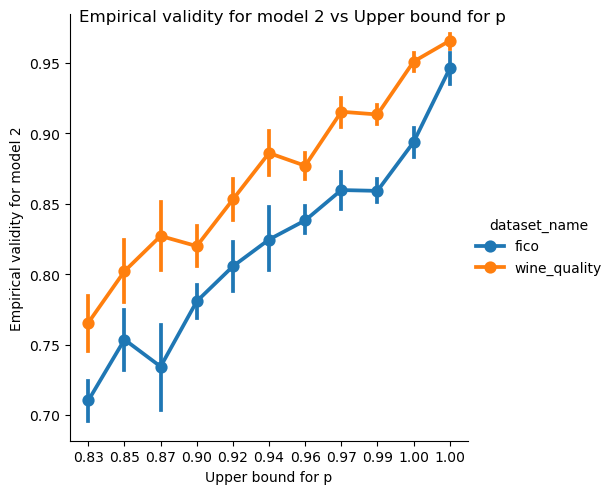

In [74]:
g = sns.catplot(data=raw_df,
            # data selection 
            x='upper_bound_beta', 
            y='robust_counterfactual_validity_model2', 
            errorbar='ci',
            hue='dataset_name',
            # ax=ax,
            kind='point',
)

xtick_labels = g.ax.get_xticklabels()
g.ax.set_xticklabels([f'{float(label.get_text()):.2f}' for label in xtick_labels])

g.set_axis_labels('Upper bound for p', 'Empirical validity for model 2')
plt.suptitle('Empirical validity for model 2 vs Upper bound for p')

plt.savefig(f'{images_dir}/misc/validity_vs_upper_bound_beta.png', dpi=300, bbox_inches='tight')


/tmp/ipykernel_24943/3582114858.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels([f'{float(label.get_text()):.2f}' for label in xtick_labels])


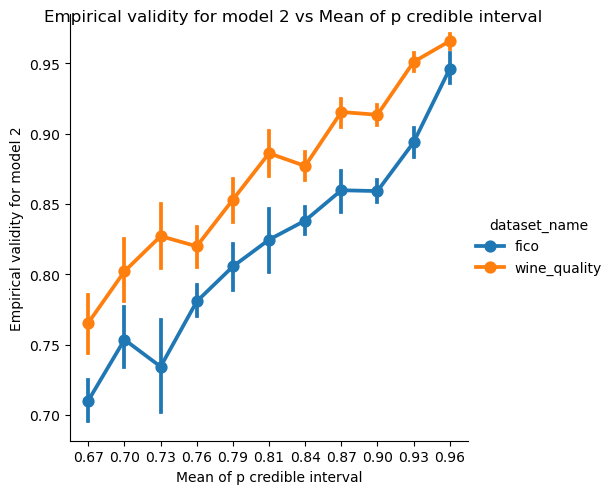

In [75]:
_df = raw_df.copy()
_df['mean_of_p_credible_interval'] = (_df['upper_bound_beta'] - _df['lower_bound_beta']) / 2 + _df['lower_bound_beta']

g = sns.catplot(data=_df,
            # data selection 
            x='mean_of_p_credible_interval', 
            y='robust_counterfactual_validity_model2', 
            errorbar='ci',
            hue='dataset_name',
            # ax=ax,
            kind='point',
            
)

xtick_labels = g.ax.get_xticklabels()
g.ax.set_xticklabels([f'{float(label.get_text()):.2f}' for label in xtick_labels])

g.set_axis_labels('Mean of p credible interval', 'Empirical validity for model 2')
plt.suptitle('Empirical validity for model 2 vs Mean of p credible interval')

plt.savefig(f'{images_dir}/misc/validity_vs_mean_of_p_credible_interval.png', dpi=300, bbox_inches='tight')



In [76]:
resultsrobx = []

tobx_results_path = 'results_combined' + '/robx'

results_list = []
recover_list = []

for dirs in os.listdir(tobx_results_path):
    results = {}
    recover = {}
    if 'results' in dirs:
        for file in os.listdir(f'{tobx_results_path}/{dirs}/results/'):
            # print(file)
            if file.endswith('.feather'):
                number = int(file.split('_')[0])
                res = pd.read_feather(f'{tobx_results_path}/{dirs}/results/{file}')
                rec = pd.read_feather(f'{tobx_results_path}/{dirs}/recover/{file}')
                
                res[['beta_confidence', 'delta_robustness']] = rec[['beta_confidence', 'delta_robustness']]

                results[number] = res
                recover[number] = rec
                
    sorted_keys = sorted(results.keys())
    for k in sorted_keys:
        results_list.append(results[k])
        recover_list.append(recover[k])

# Concatenate all the results
robx_raw_df: pd.DataFrame = pd.concat(results_list, ignore_index=True)
robx_recover_df: pd.DataFrame = pd.concat(recover_list, ignore_index=True)

# Rename beta_confidence to tau and delta_robustness to variance
robx_raw_df = robx_raw_df.rename(columns={'beta_confidence': 'tau', 'delta_robustness': 'variance'})
robx_recover_df = robx_recover_df.rename(columns={'beta_confidence': 'tau', 'delta_robustness': 'variance'})
robx_raw_df.head(5)

,experiment_type,dataset_name,k_mlps_in_B,fold_i,experiment_generalization_type,tau,variance,model2_name,x_test_sample,y_test_sample,model1_pred_proba,model1_pred_crisp,model2_pred_proba,model2_pred_crisp,base_counterfactual,base_counterfactual_model1_pred_proba,base_counterfactual_model1_pred_crisp,base_counterfactual_model2_pred_proba,base_counterfactual_model2_pred_crisp,base_counterfactual_validity,base_counterfactual_proximityL1,base_counterfactual_proximityL2,base_counterfactual_plausibility,base_counterfactual_discriminative_power,base_counterfactual_validity_model2,base_counterfactual_time,robust_counterfactual,robust_counterfactual_model1_pred_proba,robust_counterfactual_model1_pred_crisp,robust_counterfactual_model2_pred_proba,robust_counterfactual_model2_pred_crisp,robust_counterfactual_validity,robust_counterfactual_proximityL1,robust_counterfactual_proximityL2,robust_counterfactual_plausibility,robust_counterfactual_discriminative_power,robust_counterfactual_validity_model2,robust_counterfactual_L1_distance_from_base_cf,robust_counterfactual_L2_distance_from_base_cf,robust_counterfactual_time
0,Bootstrap-Architecture,fico,32,0,Bootstrap-Architecture,0.4,0.01,Model2_0,"[0.423076923076923, 0.19064124783362218, 0.192...",0,0.089378,0,0.145639,0,"[0.4054907886107322, 0.3674621710831245, 0.079...",0.508312,1,0.452049,0,1,2.491266,0.632239,0.68463,0.4,0,0.014776,"[0.5107405833305784, 0.3596986895464249, 0.070...",0.592979,1.0,0.539607,1.0,1.0,2.397353,0.574735,0.546697,0.600000,1.0,1.039486,0.086727,0.511540
1,Bootstrap-Architecture,fico,32,0,Bootstrap-Architecture,0.4,0.01,Model2_1,"[0.423076923076923, 0.19064124783362218, 0.192...",0,0.089378,0,0.042922,0,"[0.4054907886107322, 0.3674621710831245, 0.079...",0.508312,1,0.379078,0,1,2.491266,0.632239,0.68463,0.4,0,0.014776,"[0.4884297079741469, 0.3613443941234107, 0.072...",0.575650,1.0,0.606881,1.0,1.0,2.377855,0.574931,0.571576,0.466667,1.0,0.819136,0.053856,0.271883
2,Bootstrap-Architecture,fico,32,0,Bootstrap-Architecture,0.4,0.01,Model2_2,"[0.423076923076923, 0.19064124783362218, 0.192...",0,0.089378,0,0.093227,0,"[0.4054907886107322, 0.3674621710831245, 0.079...",0.508312,1,0.668090,1,1,2.491266,0.632239,0.68463,0.4,1,0.014776,"[0.46237201566645453, 0.3571173577282633, 0.08...",0.586333,1.0,0.655356,1.0,1.0,2.273342,0.587042,0.583303,0.400000,1.0,0.842353,0.069818,0.281920
3,Bootstrap-Architecture,fico,32,0,Bootstrap-Architecture,0.4,0.01,Model2_3,"[0.423076923076923, 0.19064124783362218, 0.192...",0,0.089378,0,0.150411,0,"[0.4054907886107322, 0.3674621710831245, 0.079...",0.508312,1,0.457429,0,1,2.491266,0.632239,0.68463,0.4,0,0.014776,"[0.46237201566645453, 0.3571173577282633, 0.08...",0.586333,1.0,0.527740,1.0,1.0,2.273342,0.587042,0.583303,0.400000,1.0,0.842353,0.069818,0.431172
4,Bootstrap-Architecture,fico,32,0,Bootstrap-Architecture,0.4,0.01,Model2_4,"[0.423076923076923, 0.19064124783362218, 0.192...",0,0.089378,0,0.101947,0,"[0.4054907886107322, 0.3674621710831245, 0.079...",0.508312,1,0.376229,0,1,2.491266,0.632239,0.68463,0.4,0,0.014776,"[0.4884297079741469, 0.3613443941234107, 0.072...",0.575650,1.0,0.484310,0.0,1.0,2.377855,0.574931,0.571576,0.466667,0.0,0.819136,0.053856,0.436559


In [77]:
robx_raw_df[['tau', 'variance']] = robx_recover_df[['tau', 'variance']]

In [78]:
robx_raw_df['tau'].value_counts()

0.4    5400
0.5    5400
0.6    5400
0.7    5400
0.8    5391
Name: tau, dtype: int64

In [79]:
robx_raw_df['variance'].value_counts()

0.01    13500
0.10    13491
Name: variance, dtype: int64

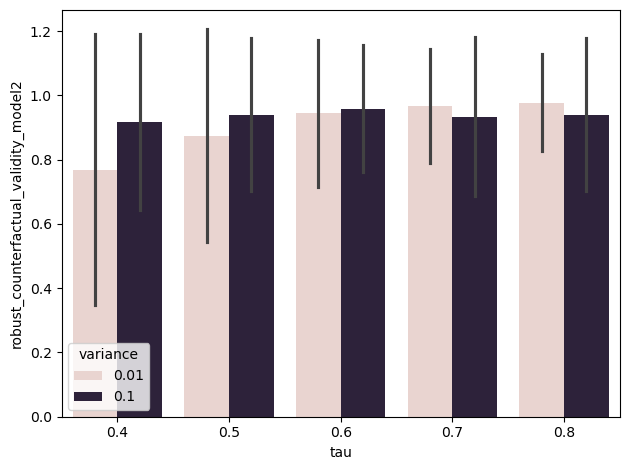

In [88]:
# Plot proximity - validity for model 2 scatter plot
sns.barplot(data=robx_raw_df, x='tau', y='robust_counterfactual_validity_model2', hue='variance', errorbar='sd')
plt.tight_layout()

In [89]:
mean_validity = robx_raw_df.groupby(['tau', 'variance']).agg(
    mean_validity=('robust_counterfactual_validity_model2', 'mean'),
    std_validity=('robust_counterfactual_validity_model2', 'std'),
)

mean_validity = mean_validity.reset_index()

mean_validity['tau'] = mean_validity['tau'].round(2)
mean_validity['mean_validity'] = mean_validity['mean_validity'].round(2)

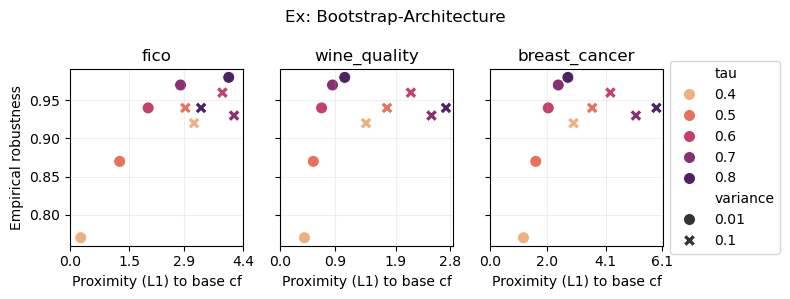

In [137]:
# Plot scatter plot of proxmity to base cf vs validity for model 2 with tau and variance as labels next to the points

cols = robx_raw_df['dataset_name'].unique().shape[0]
rows = 1

fig, ax = plt.subplots(rows,cols, figsize=(8, 3))
ax = ax.flatten()
i=0
for dataset in robx_raw_df['dataset_name'].unique():
    for experiment in robx_raw_df['experiment_type'].unique():
        data = robx_raw_df[(robx_raw_df['dataset_name'] == dataset) & (robx_raw_df['experiment_type'] == experiment)]
        
        mean_prox_to_base = data.groupby(['tau', 'variance']).agg(
            mean_prox_to_base=('robust_counterfactual_L1_distance_from_base_cf', 'mean'),
            std_prox_to_base=('robust_counterfactual_L1_distance_from_base_cf', 'std'),
        )
        
        mean_prox_to_base = mean_prox_to_base.reset_index()
        
        sns.scatterplot(x=mean_prox_to_base['mean_prox_to_base'], 
                        y=mean_validity['mean_validity'], 
                        hue=mean_prox_to_base['tau'], 
                        style=mean_prox_to_base['variance'], 
                        ax=ax[i],
                        s=75,
                        palette='flare',
                        legend=True if i == rows * cols - 1 else False,
        )
        
        # Move the legend outside the plot
        if i == rows * cols - 1:
            ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            
        # Remove the y-axis labels for all but the first plot
        if i != 0:
            ax[i].set_ylabel('')
            ax[i].set_yticklabels([])
        else:
            ax[i].set_ylabel('Empirical robustness')
            
        ax[i].set_xlabel('Proximity (L1) to base cf')
        
        ax[i].set_title(f'{dataset}')
        
        ax[i].grid(alpha=0.2)
        
        # Make x-axis have at least 4 ticks and make sure they don't disappear
        ax[i].set_xticks(np.linspace(0, ax[i].get_xlim()[1], 4).round(1))
        
        
        
        i+=1
       
plt.suptitle(f'Ex: {experiment}')
plt.tight_layout()
        

2
0 fico Bootstrap-Architecture
1 wine_quality Bootstrap-Architecture


/tmp/ipykernel_24943/1857531270.py:58: UserWarning: The markers list has more values (10) than needed (1), which may not be intended.
  sns.scatterplot(x=beta_mean_prox_to_base['mean_prox_to_base'],
/tmp/ipykernel_24943/1857531270.py:58: UserWarning: The markers list has more values (10) than needed (1), which may not be intended.
  sns.scatterplot(x=beta_mean_prox_to_base['mean_prox_to_base'],


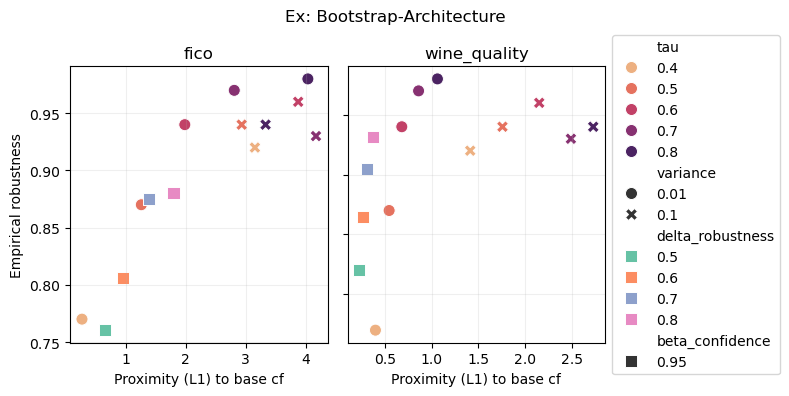

In [157]:
# Plot scatter plot of proxmity to base cf vs validity for model 2 with tau and variance as labels next to the points

robx_df = robx_raw_df.copy()
robx_df = robx_df[robx_raw_df['dataset_name'] != 'breast_cancer']


cols = robx_df['dataset_name'].unique().shape[0]
print(cols)
rows = 1

fig, ax = plt.subplots(rows,cols, figsize=(8, 4))
ax = ax.flatten()
i=0
for dataset in robx_df['dataset_name'].unique():
    for experiment in robx_df['experiment_type'].unique():
        
        print(i, dataset, experiment)
        
        data = robx_raw_df[(robx_raw_df['dataset_name'] == dataset) & (robx_raw_df['experiment_type'] == experiment)]
        
        mean_prox_to_base = data.groupby(['tau', 'variance']).agg(
            mean_prox_to_base=('robust_counterfactual_L1_distance_from_base_cf', 'mean'),
            std_prox_to_base=('robust_counterfactual_L1_distance_from_base_cf', 'std'),
        )
        
        mean_prox_to_base = mean_prox_to_base.reset_index()
        
        sns.scatterplot(x=mean_prox_to_base['mean_prox_to_base'], 
                        y=mean_validity['mean_validity'], 
                        hue=mean_prox_to_base['tau'], 
                        style=mean_prox_to_base['variance'], 
                        ax=ax[i],
                        s=75,
                        palette='flare',
                        legend=True if i == rows * cols - 1 else False,
        )
        

        
        
        data_betarob = raw_df[(raw_df['dataset_name'] == dataset) & (raw_df['experiment_type'] == experiment)]
        
        betarob_mean_prox_to_base = data_betarob.groupby(['beta_confidence', 'delta_robustness']).agg(
            mean_prox_to_base=('robust_counterfactual_L1_distance_from_base_cf', 'mean'),
            std_prox_to_base=('robust_counterfactual_L1_distance_from_base_cf', 'std'),
        )
        
        beta_mean_prox_to_base = betarob_mean_prox_to_base.reset_index()
        
        betarob_mean_validity = data_betarob.groupby(['beta_confidence', 'delta_robustness']).agg(
            mean_validity=('robust_counterfactual_validity_model2', 'mean'),
            std_validity=('robust_counterfactual_validity_model2', 'std'),
        )
        
        beta_mean_validity = betarob_mean_validity.reset_index()
        
        
        sns.scatterplot(x=beta_mean_prox_to_base['mean_prox_to_base'], 
                        y=beta_mean_validity['mean_validity'], 
                        hue=beta_mean_prox_to_base['delta_robustness'],
                        style=beta_mean_prox_to_base['beta_confidence'],
                        ax=ax[i],
                        s=75,
                        palette='Set2',
                        legend= True if i == rows * cols - 1 else False,
                        # Change markers to squares
                        markers=['s', 's', 's', 's', 's', 's', 's', 's', 's', 's'],
        )  
        
        
            # Move the legend outside the plot
        if i == rows * cols - 1:
            ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            
        # Remove the y-axis labels for all but the first plot
        if i != 0:
            ax[i].set_ylabel('')
            ax[i].set_yticklabels([])
        else:
            ax[i].set_ylabel('Empirical robustness')
            
        ax[i].set_xlabel('Proximity (L1) to base cf')
        
        ax[i].set_title(f'{dataset}')
        
        ax[i].grid(alpha=0.2)
        
        # Make x-axis have at least 4 ticks and make sure they don't disappear
        # ax[i].set_xticks(np.linspace(0, ax[i].get_xlim()[1], 4).round(1))
        
        i+=1
       
plt.suptitle(f'Ex: {experiment}')
plt.tight_layout()
        